In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import distance
from statistics import mean

## helper functions

In [2]:
#split the data into 5 different sets and return each set
def validation_sets(data, classification):
    sets = []
    sample_size = len(data)
    for index in range(0, 5):
        #for classification, make sure each class has equal representation for each set as they do in the full dataset
        if classification:
            sample_set = data.groupby('target').apply(lambda x: x.sample(frac = 0.2)).reset_index(level=0, drop=True)
        #we cant do the above for regression, so just split the data normally 
        else:
            sample_set = data.sample(n=int(sample_size*0.2))
        data = data.drop(sample_set.index)
        sets.append(sample_set.reset_index().drop(columns= 'index'))
    return sets

#return the condensed NN training set that represents a new dataset where each value in the old set is added to the new
#if it does not equal the label of the minimum distance value of the new dataset
def condensed_NN (x_train, y_train, kernel):
    new_x_train = []
    new_y_train = []
    for index in range(0, len(x_train)):
        test_sample_x, test_sample_y = [x_train[index]], y_train[index]
        #if the new dataset is empty, just add the first values into it
        if len(new_x_train)==0:
            new_x_train.append(test_sample_x)
            new_y_train.append(test_sample_y)
        #if the new dataset is not empty, find the closest neighbor and see if the labels are equal
        #if not, add it to the new dataset
        else:
            predict_sample = knn_classifier_predict(1, test_sample_x, new_x_train, new_y_train, kernel)
            if predict_sample[0] != test_sample_y:
                new_x_train.append(test_sample_x)
                new_y_train.append(test_sample_y)
    return new_x_train, new_y_train

#batch approach
def batch_edit_NN (x_train, y_train, kernel):
    tagged = []
    #runds through each feature and predicts it using the rest of the dataset. if the prediction is incorrect, remove it
    for index in range(0, len(x_train)):
        test_sample_x, test_sample_y = [x_train[index]], y_train[index]
        new_training_x, new_training_y = np.delete(x_train, index, axis=0), np.delete(y_train, index, axis=0)
        predict_sample = knn_classifier_predict(5, test_sample_x, new_training_x, new_training_y, kernel)
        if predict_sample[0] != test_sample_y:
            tagged.append(index)
    return np.delete(x_train, tagged, axis=0), np.delete(y_train, tagged, axis=0)

#returns the weights for each distance metric using the gaussian kernel function
def gaussian_kernel(distance_metrics, x):
    return np.exp(-(distance_metrics**2)/(x))

#returns the weights for each distance metric by taking the inverse of the distances, if the distance is = 0 then we 
#label the weight as 1 and make the rest of the distance weights 0
def inverse_kernel (distance_metrics):
    weights = [1/(np.abs(metric)) if metric!=0 else 1 for metric in distance_metrics ]
    if 1 in weights:
        return [1 if weight ==1 else 0 for weight in weights ]
    else:
        return weights

#this is the shell for all our model. it takes each set and tests it against the rest of the sets and returns some metrics we need 
#to evaluate our model
def k_fold_cross_validation(k, sets, classification, modifications=None, kernel = None, forest_fires = False):
    scores = []
    #iterate through each set as the test set and calculate metrics
    for index in range(0, len(sets)):
        test_set = sets[index]
        #concats the rest of the sets for training
        training_set = pd.concat([t_set for (set_index, t_set) in enumerate(sets) if set_index!=index])
        
        y_train = np.array(training_set['target'])
        #drop target so its not considered a feature
        x_train = training_set.reset_index().drop(columns= ['index','target']).values

        y_test = np.array(test_set['target'])
        x_test = test_set.reset_index().drop(columns= ['index','target']).values
        
        #here we either choose to treat the data as classification or regression
        if classification:
            #if we are doing classification, we can utilize edited nn or condensed nn
            if modifications == 'edit':
                x_train, y_train = batch_edit_NN(x_train, y_train, kernel)
            elif modifications == 'condense':
                x_train, y_train = condensed_NN(x_train, y_train, kernel)
            #runs the data through our model
            y_predict = knn_classifier_predict(k, x_test, x_train, y_train, kernel)
            #calculate and append metrics
            results = [y_predict[result_index]==actual for result_index, actual in enumerate(y_test)]
            scores.append(results.count(True)/len(results))
        else:
            #runs the data through our regression model
            y_predict = knn_regression_predict(k, x_test, x_train, y_train, kernel, forest_fires)
            #calculate and append metrics
            avg_deviation = mean([(np.abs(y_predict[i]-y_test[i]))/(y_test[i]) for i in range(0, len(y_test))])
            mae = (np.abs(y_test - y_predict)).mean()
            rsquared = 1- (((y_test-y_predict)**2).sum(axis=0)/((y_test-np.average(y_test, axis=0,))**2).sum(axis=0))
            scores.append([mae, rsquared, avg_deviation])
    return scores

## classifiers

In [3]:
#this is our classification model, a kernel can be used if specified
def knn_classifier_predict(k, x_test, x_train, y_train, kernel = None):
    predictions = []
    for sample in x_test:
        #computes the distances of each test sample with all the training samples and orders the distances to find the knn
        distances = [distance.euclidean(sample, train_sample) for train_sample in x_train]
        ordered_distances_indexes = np.argsort(distances)
        ordered_distances = np.sort(distances)
        top_k_indexes = ordered_distances_indexes[0:k]
        #this if statement is used to catch an error that could arise when we use condensed nn
        #otherwise, calculate the weighted distances if wer want to use a kernel
        if (len(ordered_distances)>k):
            k_plus_one_distance = ordered_distances[k]
            top_k_distances = ordered_distances[0:k]/k_plus_one_distance
        else:
            top_k_distances = ordered_distances[0:k]
        top_k_labels = [y_train[index] for index in top_k_indexes]
        #if we use the inverse kernel, we return the weights and pick the label that has the highest sum of weights
        if kernel == 'inverse':
            weights = inverse_kernel(top_k_distances )
            labels = np.unique(top_k_labels)
            scores = []
            for label in labels:
                indices = [index for index, val in enumerate(top_k_labels) if val == label]
                scores.append(sum(weights[index] for index in indices))
            predictions.append(labels[scores.index(max(scores))])
        #if not just take the most common label
        else:
            predictions.append(max(set(list(top_k_labels)), key=list(top_k_labels).count))
    return predictions

def knn_regression_predict(k, x_test, x_train, y_train, kernel = None, forest_fires= False):
    predictions = []
    for sample in x_test:
        #we should log(x+1) each label in the dataset because we have a lot of zero vals, we inverse this at the end of this method
        if forest_fires:
            y_train = [np.log(y+1) for y in y_train]
        #computes the distances of each test sample with all the training samples and orders the distances to find the knn
        distances = [distance.euclidean(sample, train_sample) for train_sample in x_train]
        ordered_distances_indexes = np.argsort(distances)
        ordered_distances = np.sort(distances)
        top_k_indexes = ordered_distances_indexes[0:k]
        top_k_distances = ordered_distances[0:k]
        top_k_labels = [y_train[index] for index in top_k_indexes]
        #if we use the gaussian kernel, we compute the weights and calculate y_predict as sum(weight*label)/sum(weight)
        if kernel == 'gaussian':
            weights = gaussian_kernel(top_k_distances, 2)
            numerator = np.sum(np.array(weights).astype(np.float64)*np.array(top_k_labels))
            denominator = np.sum(weights)
            if forest_fires:
                predictions.append(np.exp(numerator/denominator))
            else: 
                predictions.append(numerator/denominator)
        #if we use the inverse kernel, we compute the weights and calculate y_predict as sum(weight*label)/sum(weight)
        elif kernel == 'inverse':
            weights = inverse_kernel(top_k_distances)
            numerator = np.sum(np.array(weights).astype(np.float64)*np.array(top_k_labels))
            denominator = np.sum(weights)
            if forest_fires:
                predictions.append(np.exp(numerator/denominator))
            else: 
                predictions.append(numerator/denominator)
        #if not we just compute the mean of the labels and use this as out y_predict
        else: 
            if forest_fires:
                predictions.append(np.exp(np.mean(top_k_labels)))
            else:
                predictions.append(np.mean(top_k_labels))
    return predictions



## Ecoli - classification

In [4]:
#load the ecoli dataset and drop the sequence column because it is not a predictive value
ecoli = pd.read_csv('ecoli.data', delim_whitespace=True, header = None)
ecoli.columns = ['sequence', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'target']
ecoli = ecoli.drop(columns = ['sequence'])
#drop labels that don't have enough samples
ecoli = ecoli[ecoli['target'].isin(['cp', 'im', 'pp', 'imU', 'om'])]
#split into validation sets
sets = validation_sets(ecoli, True)

#### Normal KNN

In [5]:
accuracy = k_fold_cross_validation(4, sets, classification=True, kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.8385910603557662


#### edited NN

In [6]:
accuracy = k_fold_cross_validation(4, sets, classification=True, modifications = 'edit', kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.8711726399961693


#### condensed NN

In [7]:
accuracy = k_fold_cross_validation(5, sets, classification=True, modifications = 'condense', kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.8003696521343581


## Image Segmentation

In [8]:
segmentation = pd.read_csv('segmentation.data')
segmentation = segmentation.reset_index().rename(columns = {'index': 'target'})
segmentation = segmentation.drop(columns = 'REGION-PIXEL-COUNT')

In [9]:
labels = np.unique(segmentation['target'])
segmentation['target'] = [np.where(labels == label)[0][0] for label in segmentation['target']]

In [10]:
segmentation_norm = segmentation.drop(columns = 'target')
segmentation_norm = (segmentation_norm - segmentation_norm.mean()) / (segmentation_norm.max() - segmentation_norm.min())
segmentation_norm = segmentation_norm.join(segmentation['target'])


In [11]:
sets = validation_sets(segmentation_norm, True)

#### Normal KNN

In [12]:
accuracy = k_fold_cross_validation(4, sets, classification=True, kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.9023809523809524


#### edited NN

In [13]:
accuracy = k_fold_cross_validation(7, sets, classification=True, modifications = 'edit', kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.8038095238095238


#### condensed NN

In [14]:
accuracy = k_fold_cross_validation(2, sets, classification=True, modifications = 'condensed', kernel = 'inverse')
print (f'mean accuracy: {mean(accuracy)}')

mean accuracy: 0.8966666666666667


## Forest Fires

In [15]:
forest_fires = pd.read_csv('forestfires.data')
forest_fires = forest_fires.rename(columns = {'area': 'target'})
forest_fires['target'] = forest_fires['target'].apply(lambda x: np.log(x+1))

In [16]:
#change month and days to #s
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
forest_fires['day'] = forest_fires['day'].apply(lambda x: days.index(x) if str(x).isalpha() else x)
forest_fires['month'] = forest_fires['month'].apply(lambda x: months.index(x))

In [17]:
forest_fires_norm = forest_fires.drop(columns = ['target'])
forest_fires_norm = (forest_fires_norm - forest_fires_norm.mean()) / (forest_fires_norm.max() - forest_fires_norm.min())
forest_fires_norm = forest_fires_norm.join(forest_fires['target'])

In [18]:
forest_fires = forest_fires[['target', 'month', 'DMC']]
sets = validation_sets(forest_fires, False)

In [19]:
mae_list = []
rsquared_list = []
avg_deviation_list = []
for k in range(1, 10):
    results = k_fold_cross_validation(k, sets, classification=False, kernel='gaussian', forest_fires = True)
    mae = [metrics[0] for metrics in results]
    rsquared = [metrics[1] for metrics in results]
    avg_deviation = [metrics[2] for metrics in results]
    mae.append(mean(mae))
    rsquared.append(mean(rsquared))
    avg_deviation.append(mean(avg_deviation))
    mae_list.append(mae)
    rsquared_list.append(rsquared)
    avg_deviation_list.append(avg_deviation)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in double_scalars


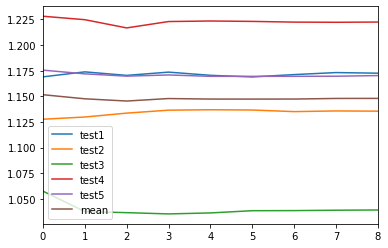

In [26]:
mae_results_df = pd.DataFrame(mae_list, columns = ['test1','test2','test3','test4','test5', 'mean'])
mae_results_df.plot()

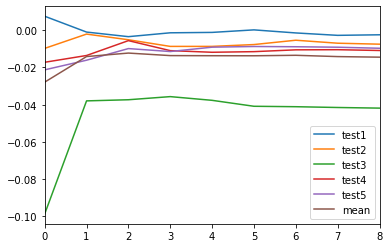

In [21]:
rsquared_results_df = pd.DataFrame(rsquared_list, columns = ['test1','test2','test3','test4','test5', 'mean'])
rsquared_results_df.plot()

## Machines

In [22]:
machines = pd.read_csv('machine.data', header=None)
machines.columns = ['vendor', 'model', 'myct', 'mmin', 'mmax', 'cach', 'chmin', 'chmax', 'target', 'erp']
machines = machines.drop(columns = ['model', 'erp'])
#machines = machines[machines['target']<301]
#machines= machines.join(pd.get_dummies(machines['vendor'])).drop(columns = 'vendor')

In [23]:
machines = machines.join(pd.get_dummies(machines['vendor'])).drop(columns = 'vendor')
machines_norm = machines.drop(columns = ['target'])
machines_norm = (machines_norm - machines_norm.mean()) / (machines_norm.max() - machines_norm.min())
machines_norm = machines_norm.join(machines['target'])

In [24]:
sets = validation_sets(machines_norm, classification = False)

In [25]:
results = k_fold_cross_validation(2, sets, classification=False)#, kernel = 'gaussian')
rsquared = [metrics[1] for metrics in results]
avg_deviation = [metrics[2] for metrics in results]
print(f'average % distance from actual: {mean(avg_deviation)}')
print(f'r-squared: {mean(rsquared)}')

average % distance from actual: 0.41983921211571956
r-squared: 0.7661805376706984
